<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/PlantVillage-Classification-ResNet50/plantVillage_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [ ]:
from google.colab import userdata
import os

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

#!/bin/bash
!kaggle datasets download emmarex/plantdisease
!unzip plantdisease.zip
!rm -rf plantdisease.zip
!rm -rf plantvillage

# Libraries

In [ ]:
# !pip install -q tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.layers import (Dense,
                                     GlobalAveragePooling2D,
                                     Input,
                                     Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pathlib
import os

2025-12-03 13:16:35.333448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764767795.551979      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764767795.615193      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Load Data

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    pathlib.Path("/kaggle/input/plantdisease/PlantVillage"),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,

)

val_ds = image_dataset_from_directory(
    pathlib.Path("/kaggle/input/plantdisease/PlantVillage"),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.


I0000 00:00:1764767822.796382      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764767822.797055      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


## Check Samples Per Class

In [ ]:
import numpy as np

class_names = train_ds.class_names
num_classes = len(class_names)

# Initialize dictionaries to store counts
train_class_counts = {name: 0 for name in class_names}
val_class_counts = {name: 0 for name in class_names}

print("Counting samples in training dataset...")
for _, labels in train_ds:
    for label in labels.numpy():
        train_class_counts[class_names[label]] += 1

print("Counting samples in validation dataset...")
for _, labels in val_ds:
    for label in labels.numpy():
        val_class_counts[class_names[label]] += 1

print("\n--- Samples per class in Training Dataset ---")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} samples")

print("\n--- Samples per class in Validation Dataset ---")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} samples")

Counting samples in training dataset...
Counting samples in validation dataset...

--- Samples per class in Training Dataset ---
Pepper__bell___Bacterial_spot: 821 samples
Pepper__bell___healthy: 1198 samples
Potato___Early_blight: 806 samples
Potato___Late_blight: 776 samples
Potato___healthy: 123 samples
Tomato_Bacterial_spot: 1713 samples
Tomato_Early_blight: 800 samples
Tomato_Late_blight: 1540 samples
Tomato_Leaf_Mold: 744 samples
Tomato_Septoria_leaf_spot: 1434 samples
Tomato_Spider_mites_Two_spotted_spider_mite: 1356 samples
Tomato__Target_Spot: 1120 samples
Tomato__Tomato_YellowLeaf__Curl_Virus: 2528 samples
Tomato__Tomato_mosaic_virus: 299 samples
Tomato_healthy: 1253 samples

--- Samples per class in Validation Dataset ---
Pepper__bell___Bacterial_spot: 176 samples
Pepper__bell___healthy: 280 samples
Potato___Early_blight: 194 samples
Potato___Late_blight: 224 samples
Potato___healthy: 29 samples
Tomato_Bacterial_spot: 414 samples
Tomato_Early_blight: 200 samples
Tomato_Late_

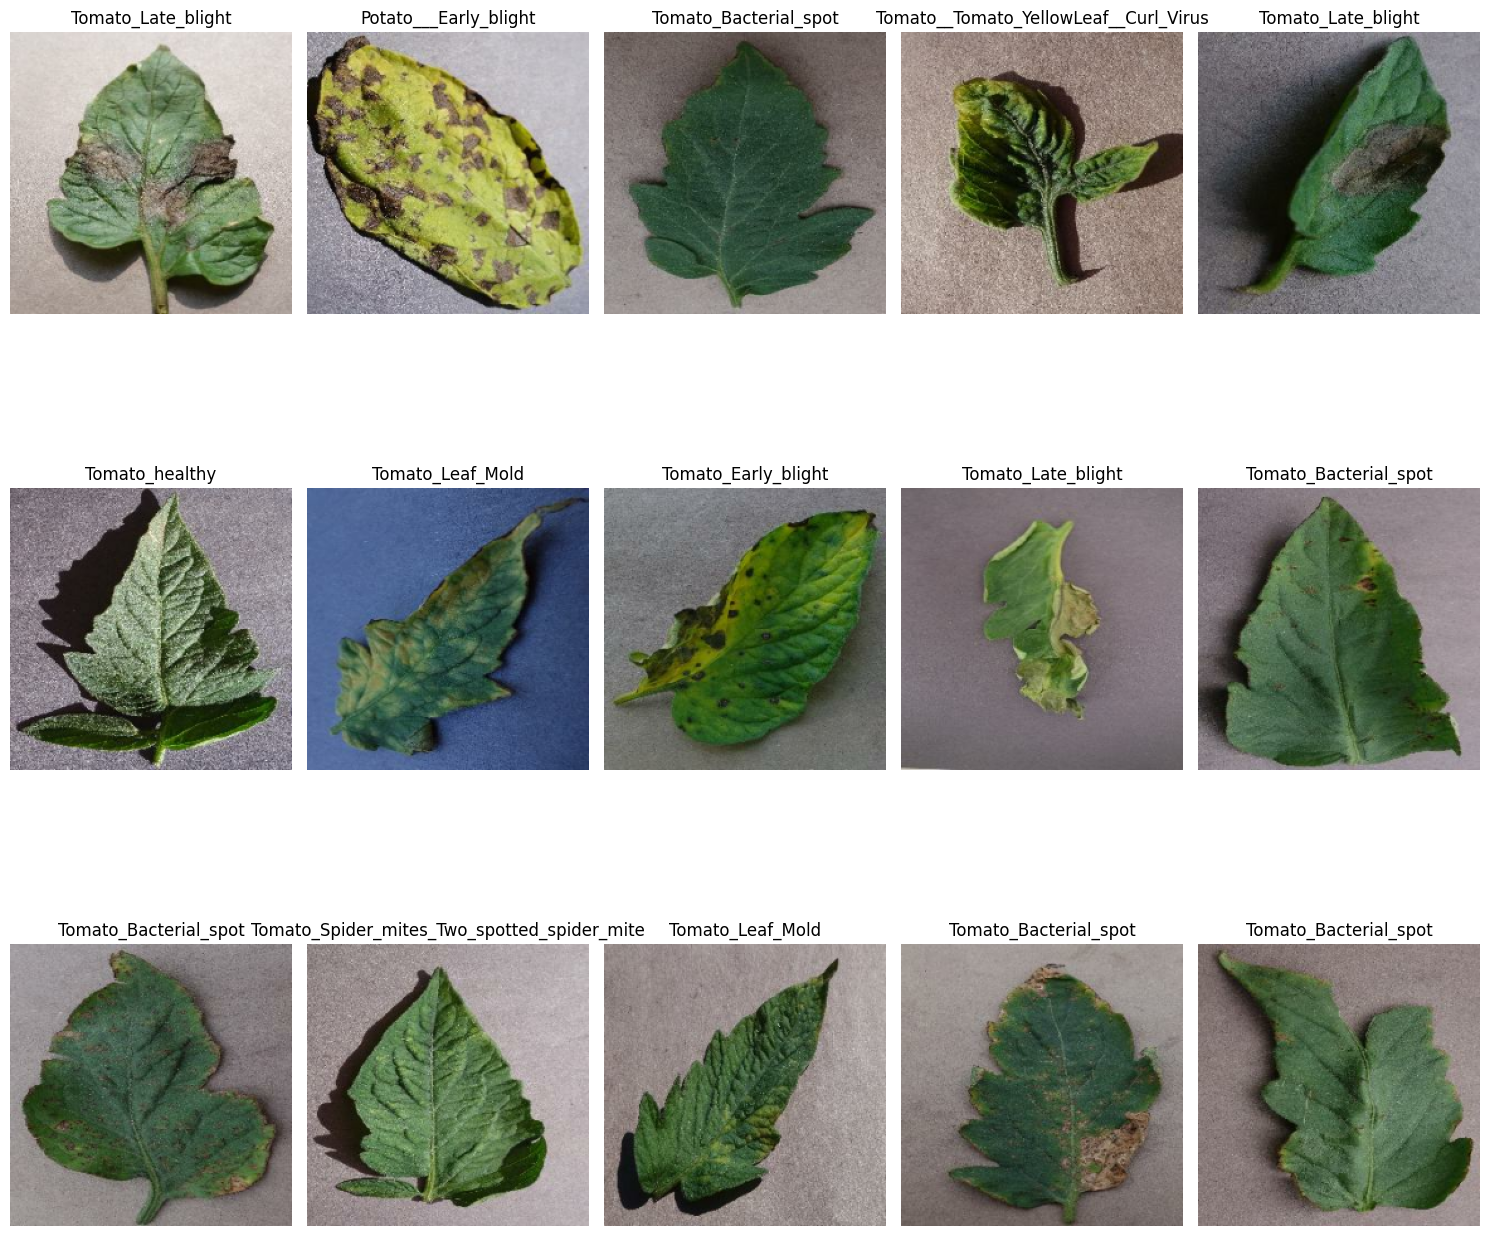

In [ ]:
# Plot samples
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

# ResNet

In [ ]:
# Preprocess
train_ds = train_ds.map(lambda x, y: (resnet_preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (resnet_preprocess_input(x), y))

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Load ResNet

In [ ]:
resnet_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SIZE + (3,)
)

# Training false
resnet_base.trainable = False
print(f"Number of layers in the base model: {len(resnet_base.trainable_weights)}")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model: 0


In [ ]:
resnet_base.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

### Add New Heads

In [ ]:
def build_resnet(base_model, num_classes):
    inputs = Input(shape=(*IMAGE_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D(name="gap_layer")(x)
    x = Dense(1024, activation="relu", name="dense_hidden_layer")(x)
    x = Dropout(0.5, name="dropout")(x)
    outputs = Dense(num_classes, activation="softmax", name="output_layer")(x)
    return Model(inputs, outputs)

model = build_resnet(resnet_base, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap_layer                       │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_layer (Dense)      │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,678,351 (97.96 MB)

 Trainable params: 2,113,551 (8.06 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Compile & Training

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Training Phase
INITIAL_EPOCHS = 5
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True),

    ModelCheckpoint(
        filepath="model.keras",
        monitor="val_loss",
        save_best_only=True)
]

history_head_resnet = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks
)

Epoch 1/5


I0000 00:00:1764767866.900230     115 service.cc:148] XLA service 0x7af21c0461d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764767866.901004     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764767866.901027     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764767868.228260     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/516 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.1042 - loss: 3.4383 

I0000 00:00:1764767874.788557     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/516 ━━━━━━━━━━━━━━━━━━━━ 74s 117ms/step - accuracy: 0.6952 - loss: 1.0225 - val_accuracy: 0.8849 - val_loss: 0.3436
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.8700 - loss: 0.3803 - val_accuracy: 0.8956 - val_loss: 0.3092
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - accuracy: 0.8955 - loss: 0.3022 - val_accuracy: 0.8864 - val_loss: 0.3452
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.9115 - loss: 0.2549 - val_accuracy: 0.9213 - val_loss: 0.2360
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.9249 - loss: 0.2156 - val_accuracy: 0.9103 - val_loss: 0.2811


### Fine Tuning `ResNet`

In [ ]:
resnet_base.trainable = True # Make all layers in the base model trainable initially

# Freeze the first 100 layers
for i, layer in enumerate(resnet_base.layers):
    if i < 100:
        layer.trainable = False
    else:
        layer.trainable = True # Ensure layers beyond 100 are trainable

print(f"Number of trainable weights in resnet_base: {len(resnet_base.trainable_weights)}")
print(f"Number of trainable weights in the full model: {len(model.trainable_weights)}")

Number of trainable weights in resnet_base: 82
Number of trainable weights in the full model: 86


In [ ]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Lower learning rate
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Continue training for 10 more epochs
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

print(f"Continuing training for {FINE_TUNE_EPOCHS} fine-tuning epochs...")
history_fine_tune_resnet = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=INITIAL_EPOCHS, # Start from where previous training left off
    callbacks=callbacks
)

Continuing training for 10 fine-tuning epochs...
Epoch 6/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 136s 211ms/step - accuracy: 0.8844 - loss: 0.3809 - val_accuracy: 0.9753 - val_loss: 0.0794
Epoch 7/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 93s 181ms/step - accuracy: 0.9845 - loss: 0.0478 - val_accuracy: 0.9753 - val_loss: 0.0739
Epoch 8/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 92s 178ms/step - accuracy: 0.9927 - loss: 0.0242 - val_accuracy: 0.9775 - val_loss: 0.0789
Epoch 9/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 91s 177ms/step - accuracy: 0.9892 - loss: 0.0344 - val_accuracy: 0.9799 - val_loss: 0.0753
Epoch 10/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 93s 181ms/step - accuracy: 0.9925 - loss: 0.0206 - val_accuracy: 0.9830 - val_loss: 0.0696
Epoch 11/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 91s 177ms/step - accuracy: 0.9938 - loss: 0.0213 - val_accuracy: 0.9685 - val_loss: 0.1208
Epoch 12/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 91s 177ms/step - accuracy: 0.9902 - loss: 0.0290 - val_accuracy: 0.9818 - val_loss: 0.0750
Epoch 13/15
516/516 ━━━━━━━━━━

### Evaluation

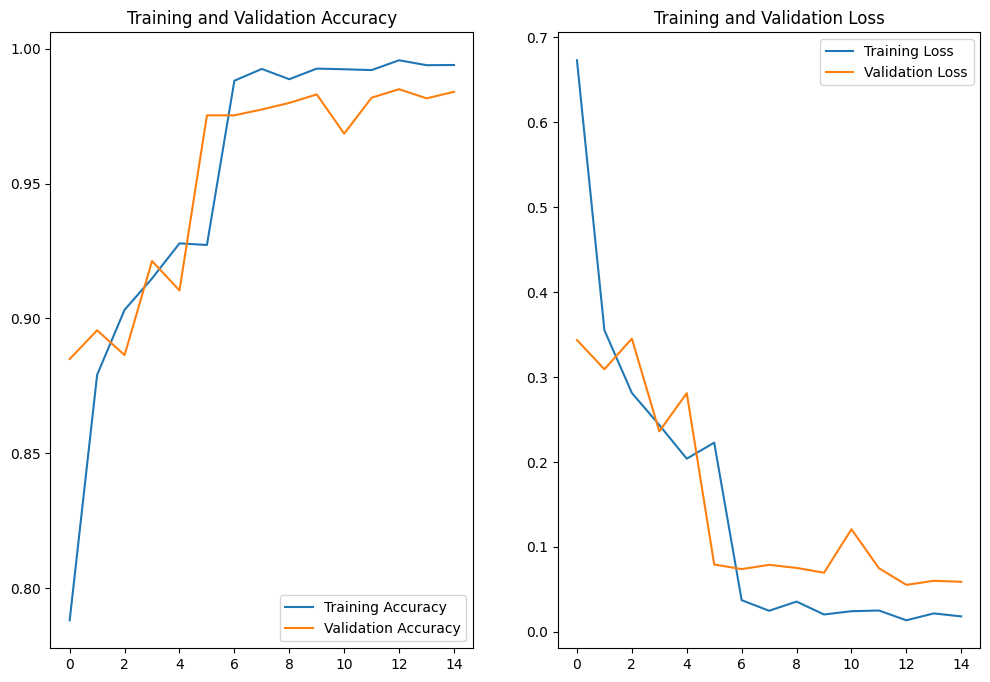

In [ ]:
import numpy as np

# Combine histories
history = {}
for key in history_head_resnet.history.keys():
    history[key] = history_head_resnet.history[key] + history_fine_tune_resnet.history[key]

acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9870 - loss: 0.0432
Validation Loss: 0.0554
Validation Accuracy: 0.9850
